In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline

torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline

pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = "catwalk_180_20:latest"
anim_tag = "mv_penguin:latest"
anim_tag = "mv_backpack:latest"
anim_tag = "mv_human_zoom_head:latest"
anim_tag = "human_mv:latest"
anim_tag = "ymca_zoom_out:latest"
anim_tag = "mv_helmet:latest"
anim_tag = "cat_mv_xatlas:latest"
anim_tag = "mv_cat_statue:latest"
anim_tag = 'lion_zoom_out_src:latest'

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)

seq = texture_anim.read_anim_seq()

In [4]:
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Lion"
uvs = seq.render_rgb_uv_maps()
vid = pil_frames_to_clip(uvs, fps=5)
display_vids([vid], title=prompt)

In [5]:
from text3d2video.mip import view_uv_res

src_resolutions = [
    view_uv_res(c, m, seq.verts_uvs, seq.faces_uvs, 512)
    for c, m in zip(seq.cams, seq.meshes)
]

src_resolutions

[1553, 881, 678, 599]

In [6]:
from pathlib import Path
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.logging import H5Logger
import torch

texgen_config = TexturingConfig(
    num_inference_steps=10,
    do_text_and_texture_resampling=True,
    use_prev_clean_tex=True,
    use_update_masks=True,
    use_referecnce_kvs=True,
    uv_res = 1400
)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    prompt,
    seq,
    conf=texgen_config,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


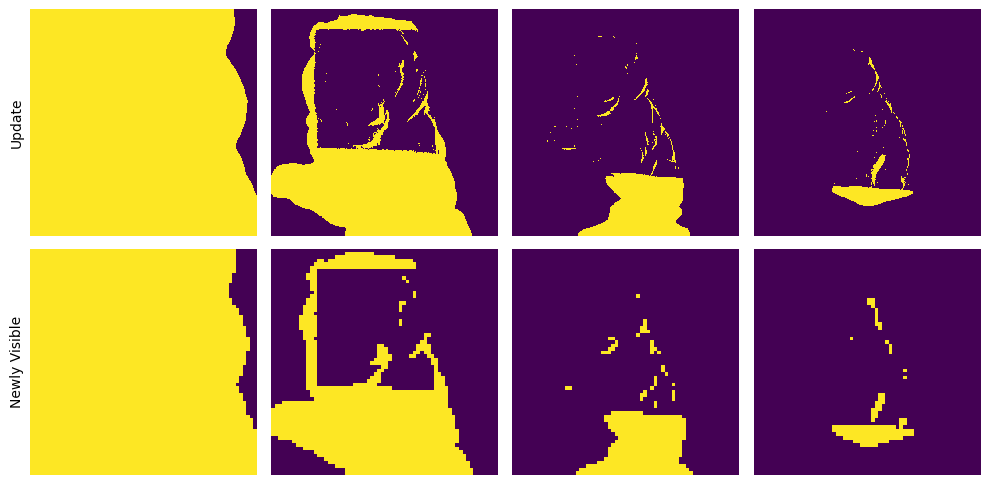

In [8]:
from text3d2video.utilities.ipython_utils import display_ims_grid

update_masks = logger.read("update_masks")
newly_visible = logger.read("newly_visible_masks")

display_ims_grid([update_masks, newly_visible], row_titles=["Update", "Newly Visible"])

In [ ]:
images_vid = pil_frames_to_clip(images.images, fps=5)
titles = [prompt]
videos = [images_vid]

display_vids(videos, titles=titles)
# display_ims(images, row_title="ref kvs")

: 

In [9]:
from text3d2video.backprojection import (
    aggregate_views_uv_texture_mean,
    compute_texel_projections,
)
import torchvision.transforms.functional as TF

projections = compute_texel_projections(
    seq.meshes, seq.cams, seq.verts_uvs, seq.faces_uvs, texgen_config.uv_res
)
images_pt = torch.stack([TF.to_tensor(x) for x in images.images]).cuda()
texture = aggregate_views_uv_texture_mean(images_pt, texgen_config.uv_res, projections)

1


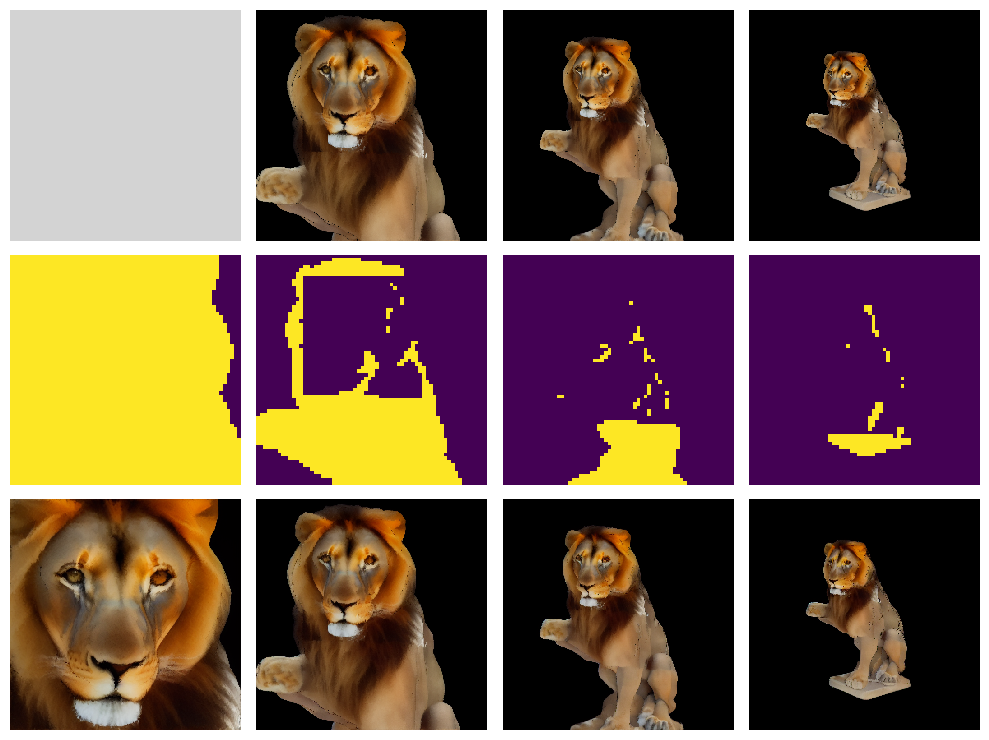

In [23]:
import torchvision.transforms.functional as TF

from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims_grid
from text3d2video.utilities.testing_utils import test_img

ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_is = sorted(logger.key_values("clean_im", "frame_i"))

t_vis = ts[9]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]
rendered = [test_img()] + [
    logger.read("rendered", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is[1:]
]

grid = object_array([rendered, newly_visible, clean_ims])
display_ims_grid(grid)

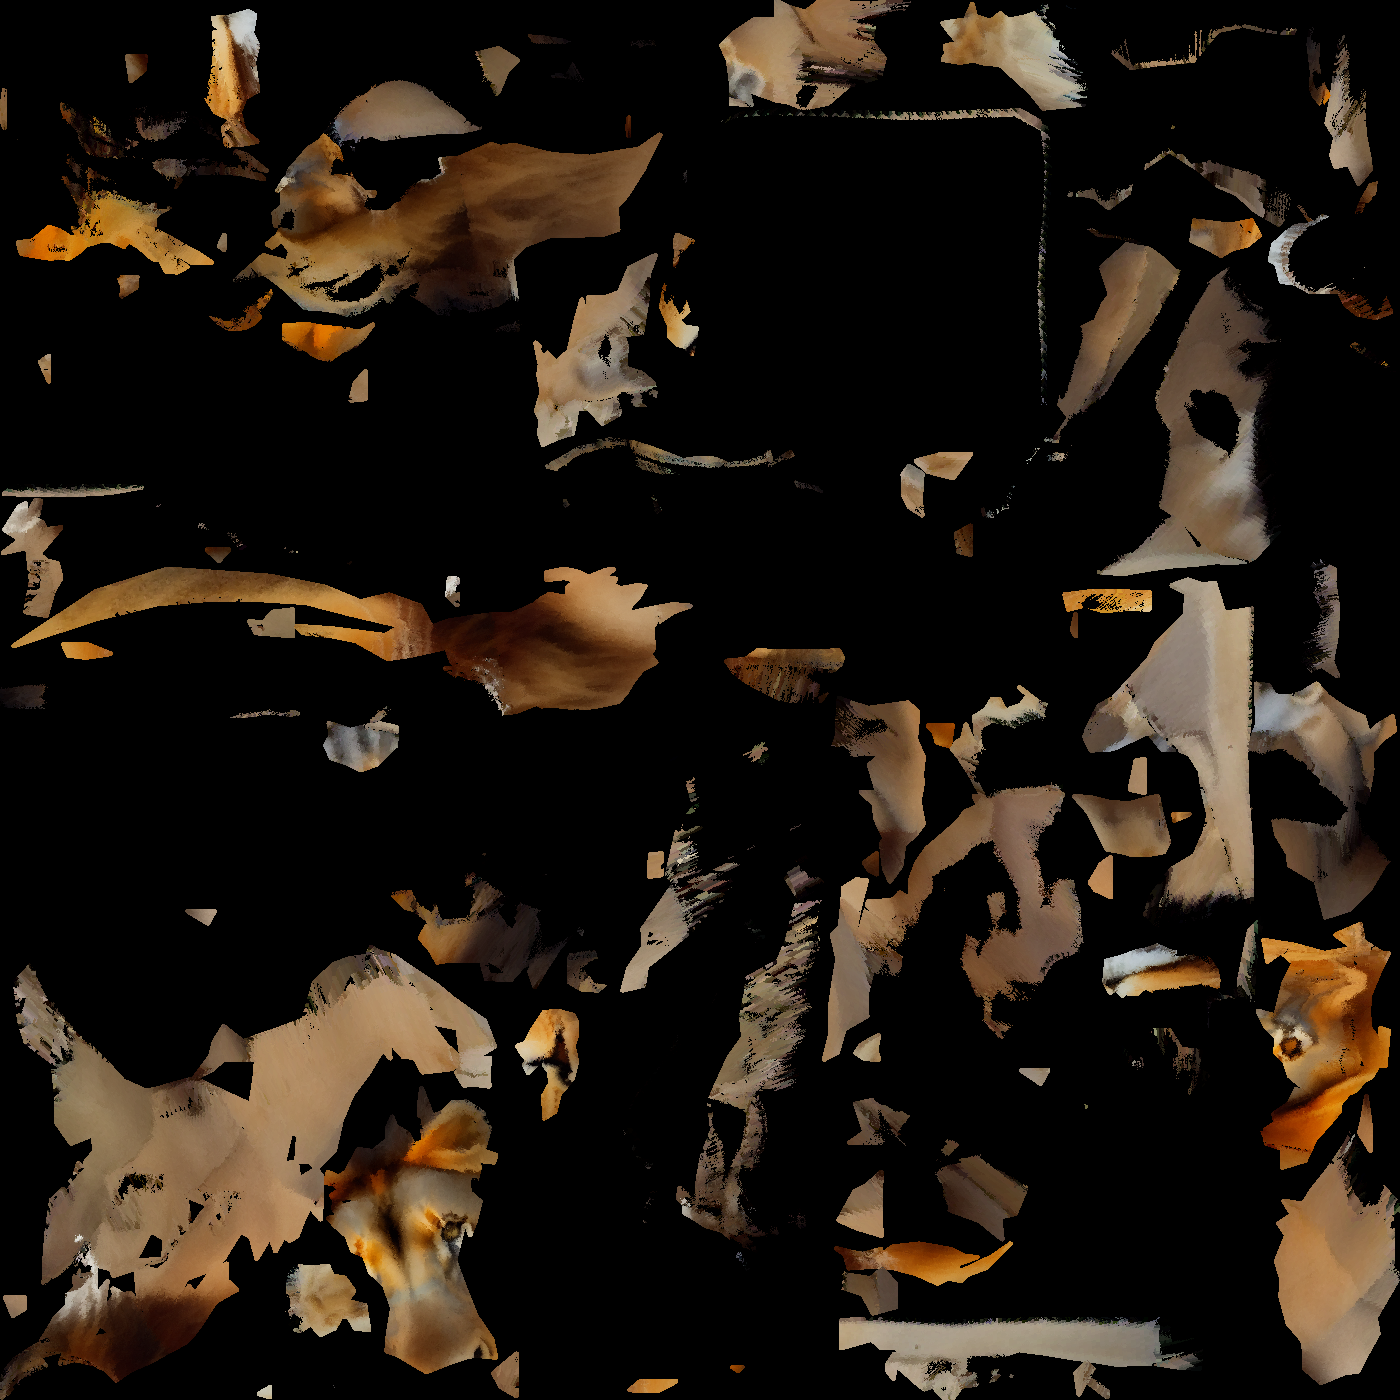

: 

In [ ]:
from text3d2video.util import hwc_to_chw


t_vis = ts[-1]
clean_tex = logger.read("clean_tex", t=t_vis)
clean_tex_pil = TF.to_pil_image(hwc_to_chw(clean_tex))
clean_tex_pil